In [44]:
import pandas as pd 
import re
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from PIL import Image

from load_classes import fetch_classdict

In [45]:
metadf = pd.read_csv('engineered.csv').drop('Unnamed: 0',axis=1)
class_dict = fetch_classdict()

In [46]:
metadf.head(3)

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  ...  left_pathological  \
0                           normal fundus  0  0  0  ...                  0   
1                           normal fundus  1  0  0  ...                  0   
2  moderate non proliferative retinopathy  0  1  0  ...                  0   

   right_pathological  left_glaucoma  right_glaucoma  left_diabetis  \
0                   0              0               0              0   
1                   0              0               0              0   
2                   0              0               0              1   

  right_diabetis left_cataract right_cataract left_normal  right_normal  
0              0             1              0           0             1  
1              0             0              0           1             1  
2              1             0              0           0             0  

[3 rows x 29 columns]

### To do 
- [x]  Re-engineering the paths to fit the current file structure.
- [x]  A pipeline script which takes a particular patient_id and prints a subplot of both left_right fundus with their diagnosis as the title.
- [x] Also has the ability to constrast a normal fundus to a detorriated one. 

### Generating Class Labels

In [47]:
classes = list(metadf.columns[19:])
metadf['pairs'] = metadf.apply(lambda x: [class_ for class_ in classes if x[class_]==1], axis=1)
metadf.head()

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   4           53        Male  4_left.jpg  4_right.jpg   
4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  ...  right_pathological  \
0                           normal fundus  0  0  0  ...                   0   
1                           normal fundus  1  0  0  ...                   0   
2  moderate non proliferative retinopathy  0  1  0  ...                   0   
3       mild nonproliferative retinopathy  0  1  0  ...                   0   
4  moderate non proliferative retinopathy  0  1  0  ...                   0   

   left_glaucoma  right_glaucoma  left_diabetis  right_diabetis left_cataract  \
0              0               0              0               0             1   
1              0               0              0               0             0   
2              0               0              1               1             0   
3              0               0              0               1             0   
4              0               0              1               1             0   

  right_cataract left_normal right_normal                            pairs  
0              0           0            1    [left_cataract, right_normal]  
1              0           1            1      [left_normal, right_normal]  
2              0           0            0  [left_diabetis, right_diabetis]  
3              0           0            0                 [right_diabetis]  
4              0           0            0  [left_diabetis, right_diabetis]  

[5 rows x 30 columns]

### Mapping Diagnosis with Class Labels

In [51]:
def map_diagnosis(item):
    diagnosis = []
    for label in item:
        diagnosis.append(class_dict[label])
    return diagnosis


In [52]:
metadf['Diagnosis'] = metadf['Labels'].apply(map_diagnosis)

In [53]:
metadf['Count'] = metadf['Diagnosis'].apply(lambda x:len(x))

In [54]:
cols = metadf.columns
newcols = pd.Series(cols).replace(class_dict).to_list()
n_metadf = metadf.copy(deep=True)
n_metadf.columns = newcols
n_metadf.head(3)

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  Normal  Diabetes  Glaucoma  ...  \
0                           normal fundus       0         0         0  ...   
1                           normal fundus       1         0         0  ...   
2  moderate non proliferative retinopathy       0         1         0  ...   

   Hypertension  Pathological  Other  \
0             0             0      0   
1             0             0      0   
2             0             0      1   

                                            filepath  labels  \
0  ../input/ocular-disease-recognition-odir5k/ODI...   ['N']   
1  ../input/ocular-disease-recognition-odir5k/ODI...   ['N']   
2  ../input/ocular-disease-recognition-odir5k/ODI...   ['D']   

                     target     filename  Labels          Diagnosis Count  
0  [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg     [C]         [Cataract]     1  
1  [1, 0, 0, 0, 0, 0, 0, 0]  1_right.jpg     [N]           [Normal]     1  
2  [0, 1, 0, 0, 0, 0, 0, 0]  2_right.jpg  [D, O]  [Diabetes, Other]     2  

[3 rows x 22 columns]

In [20]:
# Restructuring paths

In [58]:
# Data Frame Structure
# - ../input/ocular-disease-recognition-odir5k/ODIR-5K/Training Images/0_right.jpg
# Intended Structure
# - ../ODIR-data/ODIR-5K/ODIR-5K/Training Images/0_right.jpg

In [48]:
# Path restoration
sample_path = metadf['filepath'][0]
sample_path

'../input/ocular-disease-recognition-odir5k/ODIR-5K/Training Images/0_right.jpg'

In [49]:
# split and rejoin the wanted elements
sample_path = sample_path.split('/')[-1:]
sample_path

['0_right.jpg']

In [50]:
# testing
root_path = '../../ODIR-data/ODIR-5K/ODIR-5K/Merged/'
sample_path = os.path.join(root_path, *sample_path)
sample_path

'../../ODIR-data/ODIR-5K/ODIR-5K/Merged/0_right.jpg'

In [59]:
# map function
def restructure_path(path):
    root_path = '../../ODIR-data/ODIR-5K/ODIR-5K/Merged/'
    pathlist = path.split('/')[-1:]
    final_path = os.path.join(root_path, *pathlist)
    return final_path

In [60]:
# Mapping Path Restoration
metadf['filepath'] = metadf['filepath'].apply(restructure_path)

In [61]:
metadf['filepath'].head(2)[0]

'../../ODIR-data/ODIR-5K/ODIR-5K/Merged/0_right.jpg'

In [ ]:
# test
# Image.open(n_metadf['filepath'][0]) -- passed

In [62]:
# Sorting
metadf = metadf.sort_values(by='ID')
metadf.reset_index(inplace=True,drop=True)
metadf.head(2)

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   0           69      Female  0_left.jpg  0_right.jpg   

  Left-Diagnostic Keywords Right-Diagnostic Keywords  N  D  G  ...  \
0                 cataract             normal fundus  0  0  0  ...   
1                 cataract             normal fundus  0  0  0  ...   

   right_pathological  left_glaucoma  right_glaucoma  left_diabetis  \
0                   0              0               0              0   
1                   0              0               0              0   

   right_diabetis left_cataract right_cataract left_normal right_normal  \
0               0             1              0           0            1   
1               0             1              0           0            1   

                           pairs  
0  [left_cataract, right_normal]  
1  [left_cataract, right_normal]  

[2 rows x 30 columns]

### PipeLine to Plot Fundus Images

In [63]:
# Things to take into account
'''
* File name format, ID_{left | right}.jpg
'''

'\n* File name format, ID_{left | right}.jpg\n'

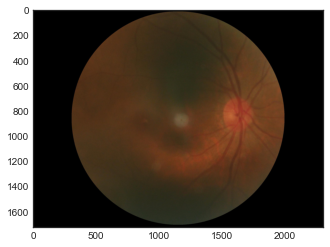

In [64]:
# testing 
plt.style.use('seaborn-white')
sample_image = metadf['filepath'][0]
plt.imshow(np.array(Image.open(sample_image)))
plt.grid = False

In [ ]:
# Read the paired_df

In [72]:
paired_df = pd.read_csv('data-archive/paired_df.csv').drop('Unnamed: 0',axis=1)
paired_df.head()

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   0           69      Female  0_left.jpg  0_right.jpg   
2   1           57        Male  1_left.jpg  1_right.jpg   
3   1           57        Male  1_left.jpg  1_right.jpg   
4   4           53        Male  4_left.jpg  4_right.jpg   

      Left-Diagnostic Keywords          Right-Diagnostic Keywords  Normal  \
0                     cataract                      normal fundus       0   
1                     cataract                      normal fundus       0   
2                normal fundus                      normal fundus       1   
3                normal fundus                      normal fundus       1   
4  macular epiretinal membrane  mild nonproliferative retinopathy       0   

   Diabetes  Glaucoma  Cataract  Age  Hypertension  Pathological  Other  \
0         0         0         1    0             0             0      0   
1         0         0         1    0             0             0      0   
2         0         0         0    0             0             0      0   
3         0         0         0    0             0             0      0   
4         1         0         0    0             0             0      1   

                                            filepath     filename      Labels  \
0  ../../ODIR-data/ODIR-5K/ODIR-5K/Merged/0_right...  0_right.jpg       ['C']   
1  ../../ODIR-data/ODIR-5K/ODIR-5K/Merged/0_left.jpg   0_left.jpg       ['C']   
2  ../../ODIR-data/ODIR-5K/ODIR-5K/Merged/1_left.jpg   1_left.jpg       ['N']   
3  ../../ODIR-data/ODIR-5K/ODIR-5K/Merged/1_right...  1_right.jpg       ['N']   
4  ../../ODIR-data/ODIR-5K/ODIR-5K/Merged/4_right...  4_right.jpg  ['D', 'O']   

               Diagnosis  Count  
0           ['Cataract']      1  
1           ['Cataract']      1  
2             ['Normal']      1  
3             ['Normal']      1  
4  ['Diabetes', 'Other']      2

In [77]:
paired_df[paired_df['Diagnosis'].str.contains('Normal')]

ID  Patient Age Patient Sex    Left-Fundus    Right-Fundus  \
2        1           57        Male     1_left.jpg     1_right.jpg   
3        1           57        Male     1_left.jpg     1_right.jpg   
12       8           59        Male     8_left.jpg     8_right.jpg   
13       8           59        Male     8_left.jpg     8_right.jpg   
124     84           51      Female    84_left.jpg    84_right.jpg   
...    ...          ...         ...            ...             ...   
4787  3485           70        Male  3485_left.jpg  3485_right.jpg   
5876  4571           51        Male  4571_left.jpg  4571_right.jpg   
5877  4571           51        Male  4571_left.jpg  4571_right.jpg   
5998  4637           45        Male  4637_left.jpg  4637_right.jpg   
5999  4637           45        Male  4637_left.jpg  4637_right.jpg   

     Left-Diagnostic Keywords Right-Diagnostic Keywords  Normal  Diabetes  \
2               normal fundus             normal fundus       1         0   
3               normal fundus             normal fundus       1         0   
12              normal fundus             normal fundus       1         0   
13              normal fundus             normal fundus       1         0   
124             normal fundus             normal fundus       1         0   
...                       ...                       ...     ...       ...   
4787            normal fundus             normal fundus       1         0   
5876            normal fundus             normal fundus       1         0   
5877            normal fundus             normal fundus       1         0   
5998            normal fundus             normal fundus       1         0   
5999            normal fundus             normal fundus       1         0   

      Glaucoma  Cataract  Age  Hypertension  Pathological  Other  \
2            0         0    0             0             0      0   
3            0         0    0             0             0      0   
12           0         0    0             0             0      0   
13           0         0    0             0             0      0   
124          0         0    0             0             0      0   
...        ...       ...  ...           ...           ...    ...   
4787         0         0    0             0             0      0   
5876         0         0    0             0             0      0   
5877         0         0    0             0             0      0   
5998         0         0    0             0             0      0   
5999         0         0    0             0             0      0   

                                               filepath        filename  \
2     ../../ODIR-data/ODIR-5K/ODIR-5K/Merged/1_left.jpg      1_left.jpg   
3     ../../ODIR-data/ODIR-5K/ODIR-5K/Merged/1_right...     1_right.jpg   
12    ../../ODIR-data/ODIR-5K/ODIR-5K/Merged/8_left.jpg      8_left.jpg   
13    ../../ODIR-data/ODIR-5K/ODIR-5K/Merged/8_right...     8_right.jpg   
124   ../../ODIR-data/ODIR-5K/ODIR-5K/Merged/84_righ...    84_right.jpg   
...                                                 ...             ...   
4787  ../../ODIR-data/ODIR-5K/ODIR-5K/Merged/3485_le...   3485_left.jpg   
5876  ../../ODIR-data/ODIR-5K/ODIR-5K/Merged/4571_le...   4571_left.jpg   
5877  ../../ODIR-data/ODIR-5K/ODIR-5K/Merged/4571_ri...  4571_right.jpg   
5998  ../../ODIR-data/ODIR-5K/ODIR-5K/Merged/4637_ri...  4637_right.jpg   
5999  ../../ODIR-data/ODIR-5K/ODIR-5K/Merged/4637_le...   4637_left.jpg   

     Labels   Diagnosis  Count  
2     ['N']  ['Normal']      1  
3     ['N']  ['Normal']      1  
12    ['N']  ['Normal']      1  
13    ['N']  ['Normal']      1  
124   ['N']  ['Normal']      1  
...     ...         ...    ...  
4787  ['N']  ['Normal']      1  
5876  ['N']  ['Normal']      1  
5877  ['N']  ['Normal']      1  
5998  ['N']  ['Normal']      1  
5999  ['N']  ['Normal']      1  

[2042 rows x 20 columns]

In [152]:
def plot_fundus(idx, paired_df, diagnosis=None, contrast=True):
    docs ='''
= Takes the ID number of the Patient and plots the patient's fundus Imagery ( Left | Right ).
- ID Range: 1-4784.
    '''
    # presets
    plt.style.use('dark_background')
    
    if diagnosis == None:
        # forging data
        idxdf = paired_df[paired_df['ID']==idx][['ID','filepath','Diagnosis']].reset_index(drop=True)
        filepath_l = idxdf.loc[0,'filepath']
        filepath_r = idxdf.loc[1,'filepath']
        # Fundus Diagnosis
        diagnosis_l = idxdf.loc[0, 'Diagnosis']
        diagnosis_r = idxdf.loc[1, 'Diagnosis']
        
        left_arr = plt.imread(filepath_l)
        right_arr = plt.imread(filepath_r)
        
        
        fig, axs = plt.subplots(ncols=2,figsize=(15,7))

        axs[0].set_title(f'Left Fundus',size=15)
        axs[0].imshow(left_arr)

        axs[1].set_title(f'Right Fundus',size=15)
        axs[1].imshow(right_arr)

        fig.suptitle(f'Patient ID: {idx}, Diagnosis - {diagnosis_l}',size=20)
        plt.show()
        plt.savefig(f'Patient_ID{idx}')
        
    elif contrast:
        pass
        
        
    

    else:
        try:
            diagnosis_df = paired_df[paired_df['Diagnosis'].str.contains(diagnosis)]
            idxdf = diagnosis_df.iloc[0:2,:][['ID','filepath']].reset_index(drop=True)
            filepath_l = idxdf.loc[0,'filepath']
            filepath_r = idxdf.loc[1,'filepath']

            left_arr = plt.imread(filepath_l)
            right_arr = plt.imread(filepath_r)
        except:
            print('No Data Found')
    

        fig, axs = plt.subplots(ncols=2,figsize=(15,7))

        axs[0].set_title(f'Left Fundus',size=15)
        axs[0].imshow(left_arr)

        axs[1].set_title(f'Right Fundus',size=15)
        axs[1].imshow(right_arr)


        fig.suptitle(f'Diagnosis - {diagnosis}',size=20)


        plt.show()
        plt.savefig(f'Patient_ID{idx}')


       



In [153]:
class_dict = fetch_classdict().values()
print(class_dict)
plot_fundus(0, paired_df, diagnosis='Pathological')


dict_values(['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'Age', 'Hypertension', 'Pathological', 'Other'])
